In [15]:
#import the necessary modules
% pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
#load the white wine quality dataset.
filename = 'winequality-white.csv' 
df = pd.read_csv(filename, sep=';')

#print the information of the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [4]:
#Separate data into poor, mediocre, and desirable wines
def quality_grading(quality):
    if quality > 6:
        return 2
    elif quality == 6:
        return 1
    else:
        return 0

In [5]:
df['desirable_label'] = df['quality'].apply(quality_grading)
count_label = df.desirable_label.value_counts().sort_index()
count_label

0    1640
1    2198
2    1060
Name: desirable_label, dtype: int64

In [6]:
df['chlorides'] = np.log(df['chlorides'])
df['residual sugar'] = np.log(df['residual sugar'])
df['total sulfur dioxide'] = np.log(df['total sulfur dioxide'])
df['free sulfur dioxide'] = np.log(df['free sulfur dioxide'])

In [7]:
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
scaled_df = scaler.fit_transform(df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']])
scaled_df = pd.DataFrame(scaled_df, columns=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])

In [8]:
scaled_df['desirable_label'] = df['desirable_label']
scaled_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,desirable_label
0,0.2,0.090909,0.333333,0.784080,0.138392,0.404390,0.545949,1.658481,-0.947368,-0.142857,-0.842105,1
1,-0.5,0.363636,0.166667,-0.668966,0.397621,-1.280108,-0.034501,0.059395,0.631579,0.142857,-0.473684,1
2,1.3,0.181818,0.666667,0.160544,0.459120,-0.180572,-0.741355,0.310680,0.421053,-0.214286,-0.157895,1
3,0.4,-0.272727,0.000000,0.278907,0.910926,0.467126,0.752317,0.424900,0.052632,-0.500000,-0.263158,1
4,0.4,-0.272727,0.000000,0.278907,0.910926,0.467126,0.752317,0.424900,0.052632,-0.500000,-0.263158,1


In [9]:
#Prepare the variables and target vectors for classification
y = scaled_df['desirable_label']
X = scaled_df.drop(['desirable_label'],axis=1)

#Split dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#Set up random forest classifier with no scaling
rf = RandomForestClassifier()

param_grid = {
    'max_depth': [10,25,50,75,100],
    'criterion': ['gini','entropy'],
    'max_features': ['auto','sqrt'],
    'min_samples_split': [2,4,8],
    'n_estimators': [10,20,40,80,100]
}

no_RF_cv = GridSearchCV(rf, param_grid, cv=5)
no_RF_cv.fit(X_train, y_train)

CPU times: user 6min 58s, sys: 1.94 s, total: 7min
Wall time: 7min 12s


In [11]:
no_RF_cv.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 80}

Best score is 0.6933861627552576
LogLoss:  0.674216027347
             precision    recall  f1-score   support

          0       0.72      0.74      0.73       525
          1       0.67      0.73      0.70       731
          2       0.78      0.61      0.68       361

avg / total       0.71      0.71      0.70      1617



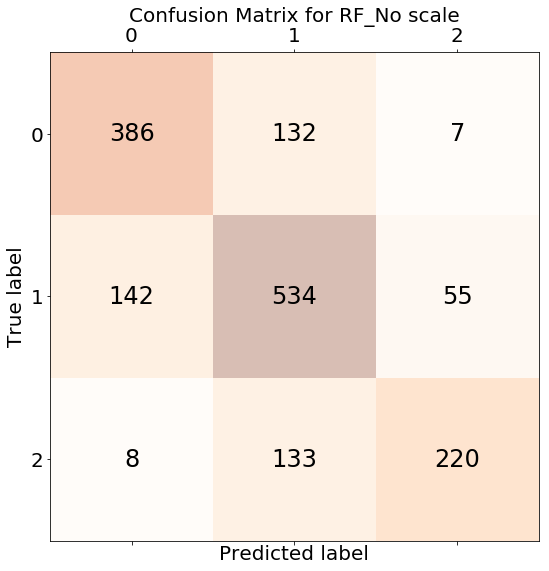

In [18]:
confusion_matrix(no_RF_cv, X_test, y_test, clf_name='RF_No scale')

Average precision score, micro-averaged over all classes: 0.78


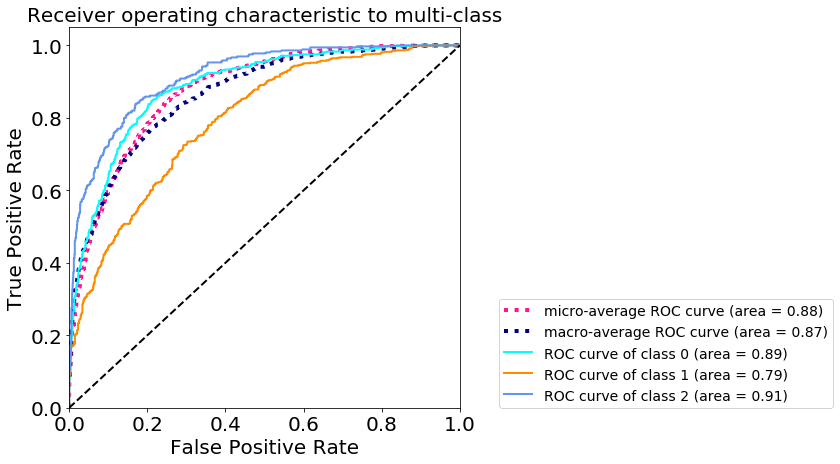

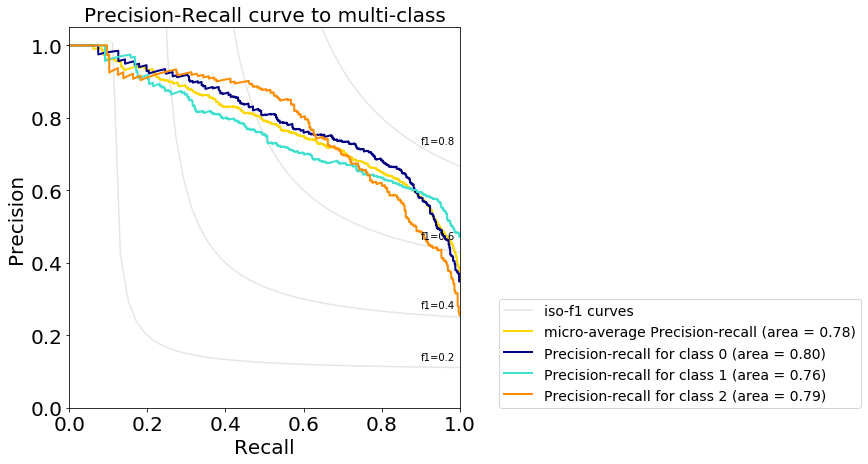

In [19]:
plots(no_RF_cv, X_test, y_test)

Let's take a look at the feature importance by recreating the model.

In [35]:
RF_cf = RandomForestClassifier(criterion= 'gini', 
                               max_depth=75, 
                               max_features= 'auto', 
                               min_samples_split=2, 
                               n_estimators=80)

RF_cf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=75, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
feature_importances = pd.DataFrame(RF_cf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
alcohol,0.124239
density,0.106224
volatile acidity,0.100776
total sulfur dioxide,0.090634
free sulfur dioxide,0.088809
residual sugar,0.086608
chlorides,0.086587
pH,0.082699
citric acid,0.082001
sulphates,0.076000


All of the feature importance are relatively close, we will be keeping all of the features for the model.

In [37]:
# Save the model by pickling
import pickle
pickle.dump(RF_cf, open('RF_cap1.pkl','wb'))

In [16]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve
def confusion_matrix(model, X_test, y_test, clf_name):
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    print("Best score is {}".format(model.best_score_))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    

    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()

In [17]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def plots(model, X_test, y_test):
        
    #ROC Curves 
        # Serialize the output
    X_test_series = X_test.values
    y_test_series = y_test.values

        # Binarize the output
    y_bin = label_binarize(y_test_series, classes=[0,1,2])
    n_classes = y_bin.shape[1]

        # Learn to predict each class against the other
    y_score = model.predict_proba(X_test_series)
    
        # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area

        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
        # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
    
        # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_bin.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_bin, y_score, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))    

        # Plot all ROC curves
    plt.figure(figsize=(7,7))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver operating characteristic to multi-class', size=20)
    plt.legend(loc=(1.1,0),fontsize=14)
    plt.show()

        #PR Curves
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(7,7))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'''.format(average_precision["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'''.format(i, average_precision[i]))

    fig = plt.gcf()
    #fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.title('Precision-Recall curve to multi-class', size=20)
    plt.legend(lines, labels, loc=(1.1,0), prop=dict(size=14))

    plt.show()